# Import Required Libraries
Import the necessary libraries, including pandas, NumPy, TensorFlow, and Keras.

In [ ]:
# NumPy is used for numerical operations
import numpy as np

# Keras is a user-friendly neural network library written in Python
from tensorflow import keras

: 

# Load and Inspect the Data
Load the training.csv file into a DataFrame and inspect its structure and contents.

In [ ]:
import tensorflow as tf

def parse_proto(proto):
    columns = {
        'detectorPositionX': tf.io.VarLenFeature(tf.float32),
        'detectorPositionY': tf.io.VarLenFeature(tf.float32),
        'centerX': tf.io.VarLenFeature(tf.float32),
        'centerY': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.FixedLenFeature([], tf.float32)
    }
    return tf.io.parse_single_example(proto, columns)
    
@tf.function(experimental_compile=True)
def convert_and_flatten(parsed_features):
    x = tf.reshape(tf.sparse.to_dense(parsed_features['detectorPositionX']), [-1])
    y = tf.reshape(tf.sparse.to_dense(parsed_features['detectorPositionY']), [-1])
    centerX = tf.reshape(tf.sparse.to_dense(parsed_features['centerX']), [-1])
    centerY = tf.reshape(tf.sparse.to_dense(parsed_features['centerY']), [-1])
    return x, y, centerX, centerY

@tf.function(experimental_compile=True)
def create_indices(x, y, centerX, centerY):
    indices_xy = tf.stack([tf.cast((x+680)/8.5, tf.int32) - 1, tf.cast((y+680)/8.5, tf.int32) - 1], axis=1)
    indices_center = tf.stack([tf.cast((centerX+680)/8.5, tf.int32) - 1, tf.cast((centerY+680)/8.5, tf.int32) - 1], axis=1)
    return indices_xy, indices_center

@tf.function(experimental_compile=True)
def update_image(indices_xy, indices_center, x, centerX):
    image = tf.zeros((156, 156), dtype=tf.float32)
    updates_xy = tf.ones_like(x)
    updates_center = -tf.ones_like(centerX)
    image = tf.tensor_scatter_nd_update(image, indices_xy, updates_xy)
    image = tf.tensor_scatter_nd_update(image, indices_center, updates_center)
    return tf.reshape(image, [156, 156, 1])

def _parse_function(proto):
    parsed_features = parse_proto(proto)
    x, y, centerX, centerY = convert_and_flatten(parsed_features)
    indices_xy, indices_center = create_indices(x, y, centerX, centerY)
    image = update_image(indices_xy, indices_center, x, centerX)
    return image, parsed_features['label'], tf.size(x) >= 3


"""def parse_proto(proto):
    columns = {
        'detectorPositionX': tf.io.VarLenFeature(tf.float32),
        'detectorPositionY': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.FixedLenFeature([], tf.float32)
    }
    return tf.io.parse_single_example(proto, columns)

@tf.function(experimental_compile=True)
def convert_and_flatten(parsed_features):
    x = tf.reshape(tf.sparse.to_dense(parsed_features['detectorPositionX']), [-1])
    y = tf.reshape(tf.sparse.to_dense(parsed_features['detectorPositionY']), [-1])
    return x, y

@tf.function(experimental_compile=True)
def create_indices(x, y):
    indices_xy = tf.stack([tf.cast((x+680)/8.5, tf.int32) - 1, tf.cast((y+680)/8.5, tf.int32) - 1], axis=1)
    return indices_xy

@tf.function(experimental_compile=True)
def update_image(indices_xy, x):
    image = tf.zeros((156, 156), dtype=tf.float32)
    updates_xy = tf.ones_like(x)
    image = tf.tensor_scatter_nd_update(image, indices_xy, updates_xy)
    return tf.reshape(image, [156, 156, 1])

def _parse_function(proto):
    parsed_features = parse_proto(proto)
    x, y = convert_and_flatten(parsed_features)
    indices_xy = create_indices(x, y)
    image = update_image(indices_xy, x)
    return image, parsed_features['label'], tf.size(x) >= 3"""

# Read the tfrecords file
dataset = tf.data.TFRecordDataset( [".training_{}.tfrecords".format(i) for i in range(0, 5)])

# Map the parse function to each record
dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Filter out entries where the length of x is less than 3
dataset = dataset.filter(lambda image, label, include: include)

# Remove the 'include' field from the dataset
dataset = dataset.map(lambda image, label, include: (image, label))

: 

In [ ]:
# Count the total number of examples in the dataset
total_size = sum(1 for _ in dataset)

# Calculate the size of each subset
train_size = int(0.99 * total_size)
val_size = int(0.01 * total_size)  # validation size
test_size = total_size - train_size - val_size  # test size 


: 

In [ ]:
train_dataset = dataset.take(train_size).batch(512)
val_dataset = dataset.skip(val_size).batch(512)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

: 

# Create the Convolutional Neural Network
Create a CNN model with 3 convolutional layers, two dense layers, and a final layer of one neuron to predict the value of the energyPrimary.

In [ ]:
# Importing the required layers for the Convolutional Neural Network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, add, Activation, Input, concatenate, LeakyReLU
from tensorflow.keras import mixed_precision, Model, regularizers

# Define the L2 regularizer
l2_reg = regularizers.l2(0.001)

# Set the policy to 'mixed_float16'
mixed_precision.set_global_policy('mixed_float16')

def inception_module(x, filters):
    # 1x1 conv
    conv1 = Conv2D(filters*.25, (1, 1), padding='same')(x)
    conv1 = LeakyReLU()(conv1)

    # 1x1 conv -> 3x3 conv
    conv2 = Conv2D(filters, (1, 1), padding='same')(x)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(filters*.5, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU()(conv2)

    # 1x1 conv -> 5x5 conv
    conv3 = Conv2D(filters, (1, 1), padding='same')(x)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(filters*.25, (5, 5), padding='same')(conv3)
    conv3 = LeakyReLU()(conv3)

    return concatenate([conv1, conv2, conv3], axis=-1)

# Define the input shapfilters
input_layer = Input(shape=(156, 156, 1))

# Add the new Conv2D layers
x = Conv2D(32, (5, 5), strides=(3, 3))(input_layer)
x = LeakyReLU()(x)
x = Conv2D(32, (3, 3), strides=(2, 2))(x)
x = LeakyReLU()(x)

x = inception_module(x, 64)
x = inception_module(x, 64)

x = Conv2D(128, (3, 3), strides=(2, 2))(x)
x = LeakyReLU()(x)

x = inception_module(x, 64)

x = Conv2D(128, (3, 3), strides=(2, 2))(x)
x = LeakyReLU()(x)

x = Dropout(0.1)(x)

x = Flatten()(x)

# Add your dense layers here
# For example:
x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dense(1, dtype='float32')(x)

model = Model(inputs=input_layer, outputs=x)

# Print the summary of the model to check the number of parameters and the structure
model.summary()
# Print the summary of the model to check the number of parameters and the structure

: 

# Train the Convolutional Neural Network
Train the CNN model using the prepared training data.

In [ ]:
# Importing the required library for the model compilation and training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from datetime import datetime
import gc

def lr_schedule(epoch, lr):
    if epoch == 3:
        return 0.0001
    elif epoch == 9:  # 3 epochs after the first change
        return 0.00001
    elif epoch == 15:  # 3 epochs after the first change
        return 0.000001
    return lr

lr_callback = LearningRateScheduler(lr_schedule)
optimizer = Adam(clipvalue=10.0)

model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'], jit_compile=True)
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[lr_callback], verbose=1)

# Save the trained model for future use
model.save('cnn_Center.keras')

: 

In [ ]:
model.save('cnn2cm_NoCenter.h5')

: 

# Evaluate the Model
Evaluate the performance of the trained model using the test data.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Error de Entrenamiento')
plt.plot(history.history['val_loss'], label='Error de Validación')
plt.title('Error Contra Epoca de Entrenamiento')
plt.xlabel('Epoca')
plt.ylabel(r'Error [$\beta$]')
plt.legend()

plt.savefig("entrenamientoCentro2cm.png")

plt.show()


: 

In [ ]:
from keras.models import load_model

# Load the model
model1 = load_model('cnn9cm_Center.keras')

: 

In [ ]:
def calculate_beta_proton(energy_gev):
    # Rest mass energy of a proton in MeV
    rest_mass_energy_mev = 938.272

    # Convert energy from GeV to MeV
    energy_mev = energy_gev * 1000

    # Calculate the Lorentz factor
    gamma = 1 + (energy_mev / rest_mass_energy_mev)

    # Calculate beta using the Lorentz factor
    beta = np.sqrt(1 - 1 / gamma**2)

    return beta

: 

3928/3928 [==============================] - 19s 5ms/step


2024-05-09 14:52:49.495266: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:52:49.495299: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601
2024-05-09 14:52:49.495312: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11574937918818842798


104/104 [==============================] - 1s 5ms/step


2024-05-09 14:52:51.022542: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:52:51.022583: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601


3701/3701 [==============================] - 17s 5ms/step


2024-05-09 14:53:08.493888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:53:08.493929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601


73/73 [==============================] - 0s 5ms/step
      1/Unknown - 0s 53ms/step

2024-05-09 14:53:09.803728: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:53:09.803765: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601


3586/3586 [==============================] - 17s 5ms/step


2024-05-09 14:53:26.881468: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:53:26.881513: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601


58/58 [==============================] - 0s 5ms/step
      1/Unknown - 0s 53ms/step

2024-05-09 14:53:28.070477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:53:28.070523: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601


3538/3538 [==============================] - 17s 5ms/step


2024-05-09 14:53:44.891328: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:53:44.891360: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601
2024-05-09 14:53:44.891373: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11574937918818842798


57/57 [==============================] - 0s 5ms/step
      1/Unknown - 0s 52ms/step

2024-05-09 14:53:46.079929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:53:46.079960: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601
2024-05-09 14:53:46.079974: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11574937918818842798


3419/3419 [==============================] - 16s 5ms/step


2024-05-09 14:54:02.352293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:54:02.352329: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601


55/55 [==============================] - 0s 5ms/step
      1/Unknown - 0s 50ms/step

2024-05-09 14:54:03.502161: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:54:03.502201: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601
2024-05-09 14:54:03.502220: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11574937918818842798


3379/3379 [==============================] - 16s 5ms/step


2024-05-09 14:54:19.495958: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:54:19.495991: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601
2024-05-09 14:54:19.496005: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11574937918818842798


52/52 [==============================] - 0s 5ms/step


2024-05-09 14:54:20.614301: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13250970339928206571
2024-05-09 14:54:20.614339: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7254355154492599601


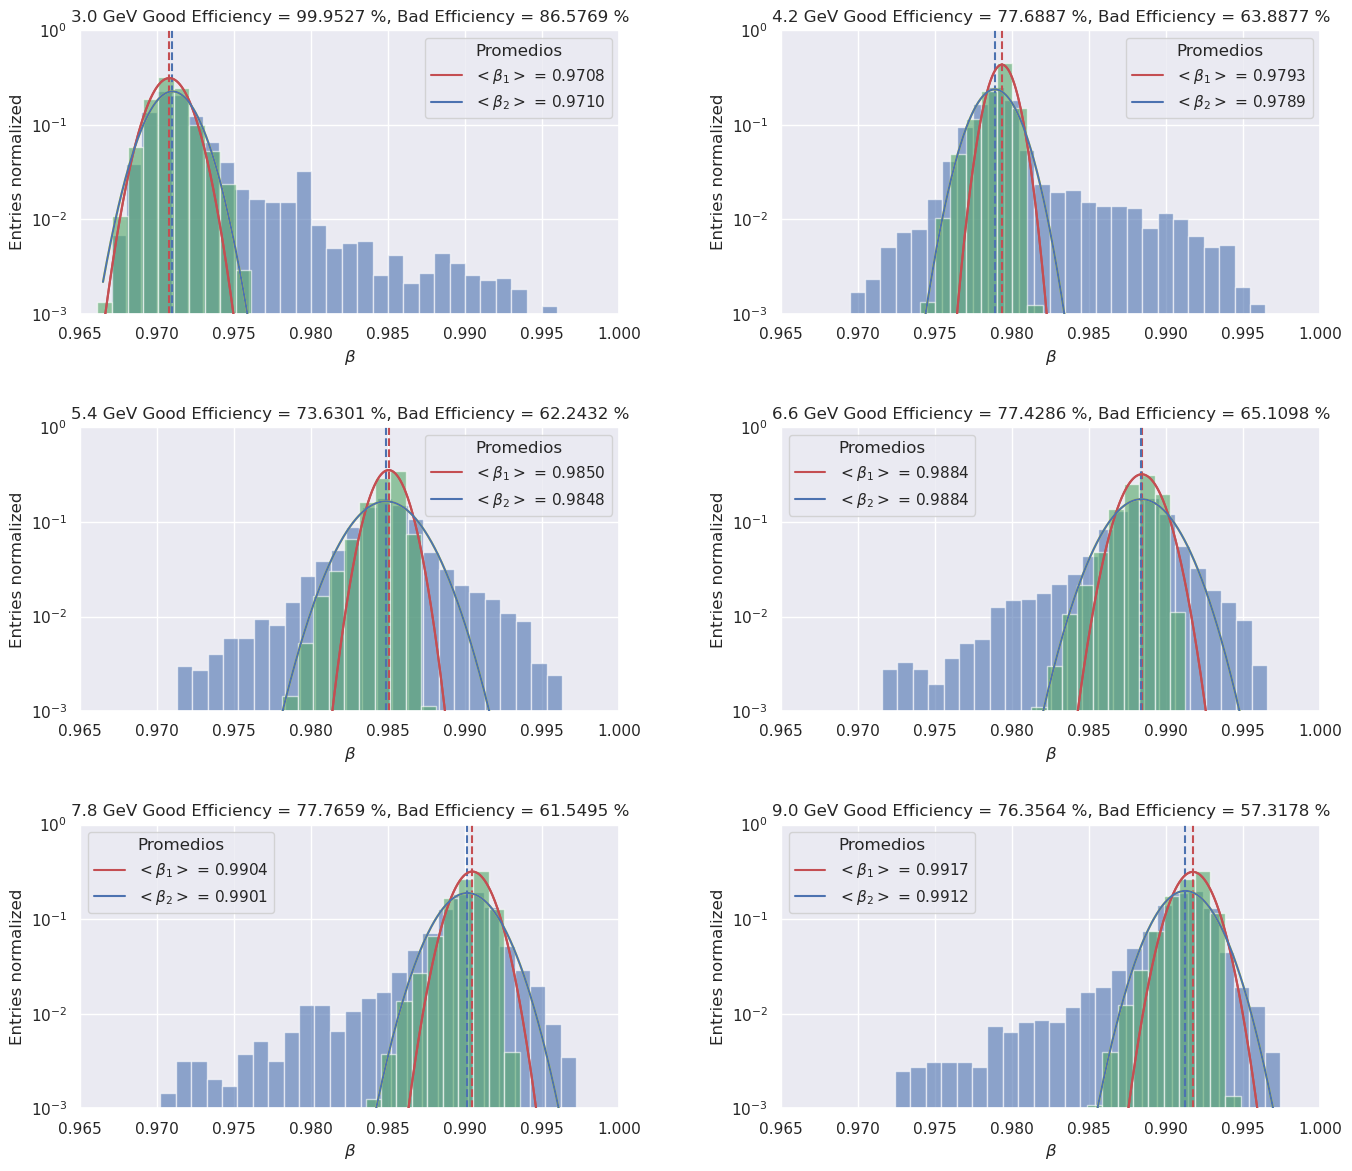

In [25]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

sns.set_theme()

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

enes = [3.0, 4.2, 5.4, 6.6, 7.8, 9.0]
efficiencies_good = []
effieciencies_bad = []

fig, axs = plt.subplots(3, 2, figsize=(16, 14))
for ax, ene in zip(axs.flatten(), enes):
    ene_str = str(ene).replace(".", "_")
    good_files = [f"./9cm/evaluacion/good{ene_str}({i}).tfrecords".format(i) for i in range(1, 4)]
    dataset1 = tf.data.TFRecordDataset(good_files)
    dataset1 = dataset1.map(_parse_function)

    bad_files = [f"./9cm/evaluacion/bad{ene_str}({i}).tfrecords".format(i) for i in range(1, 4)]
    dataset2 = tf.data.TFRecordDataset(bad_files)
    dataset2 = dataset2.map(_parse_function)

    dataset1 = dataset1.prefetch(tf.data.AUTOTUNE)
    dataset1 = dataset1.batch(64)

    dataset2 = dataset2.prefetch(tf.data.AUTOTUNE)
    dataset2 = dataset2.batch(64)

    predictions1 = model1.predict(dataset1)
    predictions2 = model1.predict(dataset2)

    beta_hat_values1 = calculate_beta_proton(predictions1)
    beta_hat_values2 = calculate_beta_proton(predictions2)

    # Flatten the array if it's multi-dimensional
    beta_hat_values1 = beta_hat_values1.flatten()
    beta_hat_values2 = beta_hat_values2.flatten()

    beta_hat1 = pd.DataFrame({"beta_hat": beta_hat_values1})
    beta_hat2 = pd.DataFrame({"beta_hat": beta_hat_values2})

    bin_width = 0.001

    bins_beta_hat1 = np.arange(min(beta_hat1["beta_hat"]), max(beta_hat1["beta_hat"]) + bin_width, bin_width)
    bins_beta_hat2 = np.arange(min(beta_hat2["beta_hat"]), max(beta_hat2["beta_hat"]) + bin_width, bin_width)

    counts_beta_hat1, _ = np.histogram(beta_hat1, bins=bins_beta_hat1)
    counts_beta_hat2, _ = np.histogram(beta_hat2, bins=bins_beta_hat2)

    counts_beta_hat1 = counts_beta_hat1 / np.sum(counts_beta_hat1)
    counts_beta_hat2 = counts_beta_hat2 / np.sum(counts_beta_hat2)

    bin_centers_beta_hat1 = (bins_beta_hat1[:-1] + bins_beta_hat1[1:]) / 2
    bin_centers_beta_hat2 = (bins_beta_hat2[:-1] + bins_beta_hat2[1:]) / 2 

    ax.bar(bin_centers_beta_hat1, counts_beta_hat1, width=np.diff(bins_beta_hat1), color='g', alpha=0.6, zorder=2)

    initial_guess_beta_hat1 = [max(counts_beta_hat1), bin_centers_beta_hat1[np.argmax(counts_beta_hat1)], np.std(beta_hat1["beta_hat"])]
    popt_beta_hat1, _ = curve_fit(gaussian, bin_centers_beta_hat1, counts_beta_hat1, p0=initial_guess_beta_hat1, maxfev=5000)

    x_beta_hat1 = np.linspace(min(bin_centers_beta_hat1), max(bin_centers_beta_hat1), 1000)
    ax.plot(x_beta_hat1, gaussian(x_beta_hat1, *popt_beta_hat1), 'r-', zorder=3)
    ax.axvline(popt_beta_hat1[1], color='r', linestyle='--')
    ax.bar(bin_centers_beta_hat2, counts_beta_hat2, width=np.diff(bins_beta_hat2), color='b', alpha=0.6, zorder=1)

    initial_guess_beta_hat2 = [max(counts_beta_hat2), bin_centers_beta_hat2[np.argmax(counts_beta_hat2)], np.std(beta_hat2["beta_hat"])]
    popt_beta_hat2, _ = curve_fit(gaussian, bin_centers_beta_hat2, counts_beta_hat2, p0=initial_guess_beta_hat2, maxfev=5000)

    x_beta_hat2 = np.linspace(min(bin_centers_beta_hat2), max(bin_centers_beta_hat2), 1000)
    ax.plot(x_beta_hat2, gaussian(x_beta_hat2, *popt_beta_hat2), '-', zorder=3, color="yellow")

    ax.axvline(popt_beta_hat2[1], color='b', linestyle='--')

    ax.set_xlim([0.965, 1])
    ax.set_ylim([1e-3, 1])

    ax.set_yscale('log')

    beta_r = calculate_beta_proton(ene)
    lower_bound = beta_r - 0.005*beta_r
    upper_bound = beta_r + 0.005*beta_r

    num_events_in_range = beta_hat1[(beta_hat1["beta_hat"] >= lower_bound) & (beta_hat1["beta_hat"] <= upper_bound)].shape[0]
    total_events = beta_hat1.shape[0]
    efficiency = num_events_in_range / total_events
    efficiencies_good.append(efficiency)

    num_bad_events_in_range = beta_hat2[(beta_hat2["beta_hat"] >= lower_bound) & (beta_hat2["beta_hat"] <= upper_bound)].shape[0]
    total_bad_events = beta_hat2.shape[0]
    bad_efficiency = num_bad_events_in_range / total_bad_events
    effieciencies_bad.append(bad_efficiency)

    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel('Entries normalized')

    line_beta_hat1, = ax.plot(x_beta_hat1, gaussian(x_beta_hat1, *popt_beta_hat1), 'r-', zorder=3) 
    line_beta_hat2, = ax.plot(x_beta_hat2, gaussian(x_beta_hat2, *popt_beta_hat2), 'b-', zorder=3)

    # Add a legend
    ax.legend([line_beta_hat1, line_beta_hat2], [f'$<\\beta_{{1}}>$ = {popt_beta_hat1[1]:.4f}', f'$<\\beta_{{2}}>$ = {popt_beta_hat2[1]:.4f}'], title='Promedios')

    # Set the title
    ax.set_title(f'{ene} GeV Good Efficiency = {efficiency*100:.4f} %, Bad Efficiency = {bad_efficiency*100:.4f} %')

plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust these values as needed

plt.show()


array([[<Axes: title={'center': 'beta_hat'}>]], dtype=object)

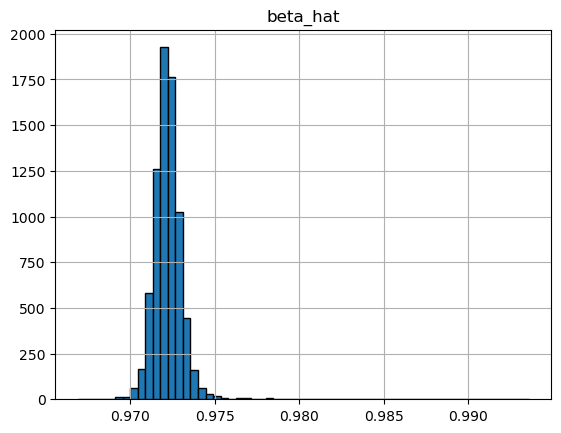

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

fig, ax = plt.subplots(figsize=(10, 6))

# Define the bin width
bin_width = 0.001

bins_beta_hat1 = np.arange(min(beta_hat1), max(beta_hat1) + bin_width, bin_width)
bins_beta_hat2 = np.arange(min(beta_hat2), max(beta_hat2) + bin_width, bin_width)

counts_beta_hat1, _ = np.histogram(beta_hat1, bins=bins_beta_hat1)
counts_beta_hat2, _ = np.histogram(beta_hat2, bins=bins_beta_hat2)

counts_beta_hat1 = counts_beta_hat1 / np.sum(counts_beta_hat1)
counts_beta_hat2 = counts_beta_hat2 / np.sum(counts_beta_hat2)

bin_centers_beta_hat1 = (bins_beta_hat1[:-1] + bins_beta_hat1[1:]) / 2
bin_centers_beta_hat2 = (bins_beta_hat2[:-1] + bins_beta_hat2[1:]) / 2 

ax.bar(bin_centers_beta_hat1, counts_beta_hat1, width=np.diff(bins_beta_hat1), color='g', alpha=0.6, zorder=2)

initial_guess_beta_hat1 = [max(counts_beta_hat1), bin_centers_beta_hat1[np.argmax(counts_beta_hat1)], np.std(beta_hat1)]
popt_beta_hat1, _ = curve_fit(gaussian, bin_centers_beta_hat1, counts_beta_hat1, p0=initial_guess_beta_hat1, maxfev=5000)

x_beta_hat1 = np.linspace(min(bin_centers_beta_hat1), max(bin_centers_beta_hat1), 1000)
ax.plot(x_beta_hat1, gaussian(x_beta_hat1, *popt_beta_hat1), 'r-', zorder=3)
ax.axvline(popt_beta_hat1[1], color='r', linestyle='--')
ax.bar(bin_centers_beta_hat2, counts_beta_hat2, width=np.diff(bins_beta_hat2), color='b', alpha=0.6, zorder=1)

initial_guess_beta_hat2 = [max(counts_beta_hat2), bin_centers_beta_hat2[np.argmax(counts_beta_hat2)], np.std(beta_hat2)]
popt_beta_hat2, _ = curve_fit(gaussian, bin_centers_beta_hat2, counts_beta_hat2, p0=initial_guess_beta_hat2, maxfev=5000)

x_beta_hat2 = np.linspace(min(bin_centers_beta_hat2), max(bin_centers_beta_hat2), 1000)
ax.plot(x_beta_hat2, gaussian(x_beta_hat2, *popt_beta_hat2), '-', zorder=3, color="yellow")

ax.axvline(popt_beta_hat2[1], color='b', linestyle='--')

ax.set_xlim([0.965, 1.2])
ax.set_ylim([1e-3, 1])

ax.set_yscale('log')

beta_r = calculate_beta_proton(ene)

ax.set_xlabel(r'$\beta$')
ax.set_ylabel('Entries normalized')

line_beta_hat1, = ax.plot(x_beta_hat1, gaussian(x_beta_hat1, *popt_beta_hat1), 'r-', zorder=3) 
line_beta_hat2, = ax.plot(x_beta_hat2, gaussian(x_beta_hat2, *popt_beta_hat2), 'b-', zorder=3)

# Add a legend
ax.legend([line_beta_hat1, line_beta_hat2], [f'$<\\beta_{{1}}>$ = {popt_beta_hat1[1]:.4f}', f'$<\\beta_{{2}}>$ = {popt_beta_hat2[1]:.4f}'], title='Mean values')

# Set the title
ax.set_title(f'{ene} GeV Proton with Likelihood')

# Save the figure
fig.savefig("3pLike.png")

# Display the plot
plt.show()

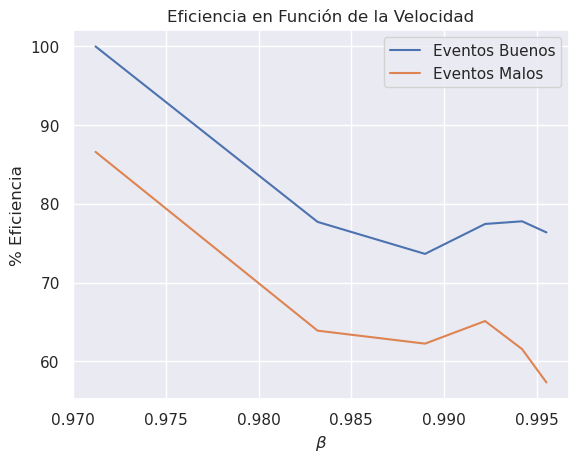

In [31]:
betas = [calculate_beta_proton(ene) for ene in enes]

plt.title("Eficiencia en Función de la Velocidad")

plt.xlabel(r'$\beta$')
plt.ylabel("% Eficiencia")

line_good, = plt.plot(betas, [efe*100 for efe in efficiencies_good])
line_bad, = plt.plot(betas, [efe*100 for efe in effieciencies_bad])

plt.legend([line_good, line_bad], ["Eventos Buenos", "Eventos Malos"])

plt.show()